# DATA 604 - Final Project

Mael Illien

* Using SimPy, write a process simulation that includes waiting time (discrete event simulation). You may use any topic of interest to you. Write the simulation and all of the following in Jupyter. Each element is worth 5 points and will be graded using the rubric shown here.
* 1. State the problem and its significance.
* 2. Provide a flow-chart model. 
* 3. Simulate the process for the appropriate number of iterations (justify)
* 4. Justify the validity of the model and discuss how you verified it.
* 5. State your conclusions/ findings from the model. 
* 6. Generate appropriate graphs (more than one) to illustrate the results and provide a PowerPoint presentation to share with your colleagues. Post this to the discussion.


## Introduction & Setup

This goal of this project is to optimize the Sharpe ratio of a portfolio via simulation. This Monte Carlo simulation is significant in its usage to investors in determining the allocation of stock positions in a portfolio that maximizes risk adjusted returns. The way this high-return low-volativity measure will be recorded is through the use of the Sharpe ratio. The ratio is used to evaluate whether a portfolio's returns were good investments and not the result of excess risk.

This work builds upon simulation elements presented in the ModSimPy library and associated text. While the ModSimPy library is not explicitly used in the code presented, the same methodologies are applied.

The simulation works with a handful of stocks whose daily returns for the year 2019 are used to update a portfolio object with random initial allocation weights on every iteration. The simulation is run 500 times, which proved to be a good compromise between a variety of portfolio returns and and run time. 

In [1]:
import os
import numpy as np
import pandas as pd
import random
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

### Data Import

The data is contained in flat files, generated from a stock price database maintained by the author. Five stocks are selected from various sectors in order to diversify the returns.

In [2]:
stock_names = [file.replace('.csv','') for file in os.listdir('.') if '.csv' in file]
files = [file for file in os.listdir('.') if '.csv' in file]
stock_names

['V', 'BAC', 'NKE', 'AAPL', 'DLTR']

In [3]:
def load_data(csv_file):
    df = pd.read_csv(csv_file)
    df = df.set_index('price_date')
    return df

The daily stock prices are entered in a data frame as follows.

In [4]:
stock_frames = [load_data(file) for file in files]
stocks = pd.concat(stock_frames, axis=1, join='inner')
stocks.columns = stock_names
stocks

,V,BAC,NKE,AAPL,DLTR
price_date,,,,,
2019-01-02,131.6611,24.2500,73.0811,154.7950,91.20
2019-01-03,126.9165,23.8614,71.7884,139.3763,90.76
2019-01-04,132.3842,24.8524,73.6633,145.3261,92.89
2019-01-07,134.7713,24.8330,74.7192,145.0027,97.96
2019-01-08,135.5043,24.7844,75.7158,147.7669,98.60
...,...,...,...,...,...
2019-12-24,186.9857,34.9967,99.8629,282.8313,93.23
2019-12-26,188.5707,35.2948,100.4314,288.4428,92.08
2019-12-27,188.8000,35.1259,101.2890,288.3333,92.84


Stock returns will be used to update the portfolio holdings on every iteration of the system time. Logarithmic returns are often used instead of arithmetic returns. In this assignment we will focus on the later as shown below.

In [5]:
stock_returns = stocks.pct_change(1) # arithmetic stocks returns
stock_log_returns = np.log(stocks/stocks.shift(1)) # logarithmic stocks returns (not used)
stock_returns

,V,BAC,NKE,AAPL,DLTR
price_date,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.036036,-0.016025,-0.017689,-0.099607,-0.004825
2019-01-04,0.043081,0.041532,0.026117,0.042689,0.023468
2019-01-07,0.018032,-0.000781,0.014334,-0.002225,0.054581
2019-01-08,0.005439,-0.001957,0.013338,0.019063,0.006533
...,...,...,...,...,...
2019-12-24,0.002619,0.001422,0.000999,0.000951,0.008546
2019-12-26,0.008477,0.008518,0.005693,0.019840,-0.012335
2019-12-27,0.001216,-0.004785,0.008539,-0.000380,0.008254


## Simulation

The use of System and State objects from ModSimPy is replaced by the objects defined below, allowing for more control over the simulation.

The System object holds a number of attributes include the duration of the simulation, the stock returns to be used for updating portfolios, the names of the stocks traded and an initial capital.

In [6]:
class System():
    def __init__(self, stock_returns, init_capital):
        self.t0 = 0
        self.t_end = len(stock_returns)
        self.stock_returns = stock_returns
        self.stock_names = list(self.stock_returns.columns)
        self.init_capital = init_capital

The Porfolio object is analogous to the State object from ModSimPy and will get updated on every system iteratiion by the update_holdings function. It holds a set of initial weights of stock allocations and the holdings data frame which will get iteratively built upon  during the simulation.

In [7]:
class Portfolio():
    def __init__(self, stock_names, init_weights, capital):
        self.init_weights = init_weights
        #self.current_weights = self.calculate_current_weights()
        self.capital = capital
        self.holdings = pd.DataFrame([self.init_weights], columns=stock_names) * capital
        
    def update_holdings(self, daily_returns):
        "Multiply latest holdings by daily_returns at system.t"
        updated_holdings = np.multiply(self.latest_holdings(), [ret+1 for ret in daily_returns])
        self.holdings = self.holdings.append(updated_holdings)
    
    def latest_holdings(self):
        return port.holdings.iloc[[-1]]
    
    def calculate_port_value(self):
        return sum(self.holdings.iloc[-1])

### Structure

The simulation is broken down into the following steps:

- Initialize simulation parameters including a random seed, number of portfolios and initial capital
- Initialize arrays to store the simulation results: weight allocation, returns, volatility, sharpe ratio and capital
- Build System object
- Simulate `num_ports` portfolios. For every portfolio:
    - Assign random initial weights
    - Build Portfolio object
    - Initialize starting capital
    - For every time step `t` of System:
        - Get daily stock returns
        - Update Portfolio holdings
        - Record capital 
    - Compute and record metrics of simulation iteration `i`: weights, returns, volatility and Sharpe ratio
    
    


In [8]:
# initialize
random.seed(604)
num_ports = 500
init_capital = 1e6
all_init_weights = np.zeros((num_ports, len(stocks.columns)))
#all_final_weights = np.zeros((num_ports, len(stocks.columns)))
returns = np.zeros(num_ports)
volatility = np.zeros(num_ports)
sharpe = np.zeros(num_ports)

# Build system
system = System(stock_returns, init_capital)

capital = np.zeros((system.t_end, num_ports))

# Simulate Portfolio
for i in range(num_ports):
    
    # Assign random weights normalized to sum to 1
    weights = np.array(np.random.random(len(system.stock_names))) 
    init_weights = weights/np.sum(weights)
    all_init_weights[i,:] = init_weights
    
    # Build portfolio and initialize series with the original capital
    port = Portfolio(system.stock_names, init_weights, system.init_capital)
    
    # Initialize capital series with the original capital
    capital[0,i] = port.calculate_port_value()
    
    # Update portfolio holdings daily and record capital at time t
    for t in range(system.t0+1, system.t_end):
        
        daily_returns = system.stock_returns.iloc[t].values.tolist()
        port.update_holdings(daily_returns)
        capital[t,i] = port.calculate_port_value()
    
    # Compute and record metrics

    # Record weights
    #all_final_weights[i,:] = weights
    
    # Record expected average returns (annualized)
    ret = pd.Series(capital[:,i]).pct_change(1)
    returns[i] = ret.mean() * 252

    # Record expected volatility (annualized)
    volatility[i] = ret.std() * (252**0.5) 
     
    # Record Sharpe Ratio (annualized)
    sharpe[i] = returns[i]/volatility[i]

### Results

The function below selects the best portfolio as determined by the maximum Sharpe Ratio achieved. It also prints out the resulting returns, volality as well as the original weights the portfolio was built from.

In [9]:
def display_results(returns, volatility, sharpe):
    s_arg_max = sharpe.argmax()
    s_max = sharpe.max()
    init_alloc = all_init_weights[s_arg_max]
    #final_alloc = all_final_weights[s_arg_max]/np.sum(all_final_weights[s_arg_max])
    max_sr_ret = returns[s_arg_max]
    max_sr_vol = volatility[s_arg_max]
    
    print("Best Portofolio: {}".format(s_arg_max))
    print("Max Sharpe Ratio achieved: {}".format(round(s_max,3)))
    print("Stocks: {}".format(stock_names))
    print("Inital Weight Allocation: {}".format([round(w, 3) for w in init_alloc]))
    #print("Final Weight Allocation: {}".format([round(w, 3) for w in final_alloc]))
    print("Returns: {}".format(round(max_sr_ret,3)))
    print("Volatility: {}".format(round(max_sr_vol,3)))
    
    plt.figure(figsize=(12,8))
    plt.scatter(volatility, returns, c=sharpe, cmap='plasma')
    plt.colorbar(label='Sharpe Ratio')
    plt.title('Simulated Sharpe Ratios')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    # add a red dot for max_sr_vol & max_sr_ret
    plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolors='black')

The plot below of the simulated Sharpe ratios plotted on returns and volality axes, shows the distribution of the simulated portfolios. High Sharpe portfolios are more yellow and the maximum is singled out in red. Notice that these simulated portfolios all yield a Sharpe ratio about 1 which is considered good performance. No portfolio holding the 5 selected stocks resulted in a negative return.

Best Portofolio: 414
Max Sharpe Ratio achieved: 2.706
Stocks: ['V', 'BAC', 'NKE', 'AAPL', 'DLTR']
Inital Weight Allocation: [0.221, 0.063, 0.119, 0.571, 0.025]
Returns: 0.538
Volatility: 0.199


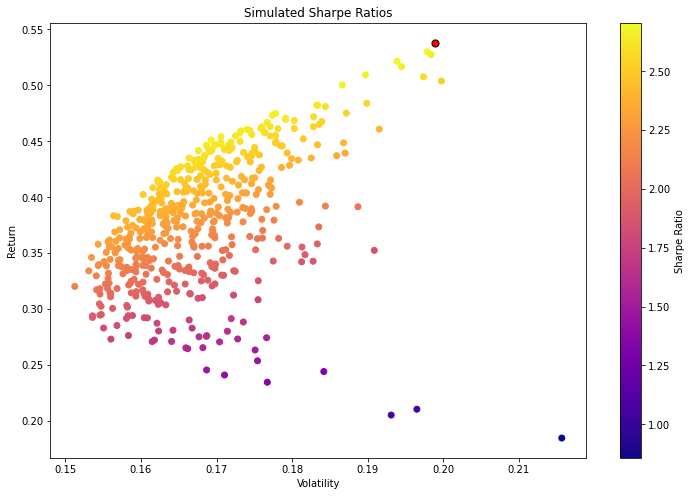

In [10]:
display_results(returns, volatility, sharpe)

### Verification

We will verify if the simulation model works as expected, with the help of a few graphs.

Firstly, we revisit the assumption that investment returns are normally distributed with a histogram and the Shapiro-Wilk normality test. We find that this is indeed the case (tail end).

Include std dev

Text(0.5, 0, 'Returns')

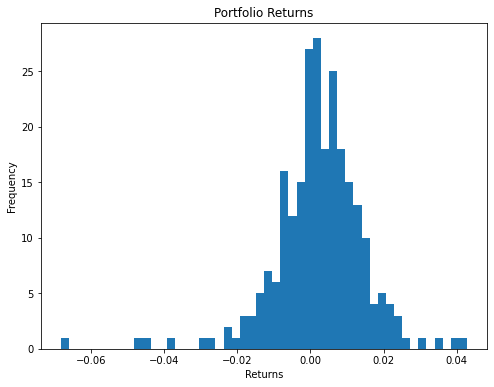

In [11]:
plt.figure(figsize=(8,6))
pd.Series(capital[:,sharpe.argmax()]).pct_change(1).plot(kind='hist', bins=50)
plt.title('Portfolio Returns')
plt.xlabel('Returns')

In [12]:
shapiro_test = stats.shapiro(capital[:,sharpe.argmax()])
shapiro_test

(0.9718963503837585, 7.032448047539219e-05)

Secondly, since the Sharpe Ratio is used as a performance measure, let's compare the performance of the best and worst portfolios. The best portfolio not only ends the year with higher returns but it also has steadier returns. Notice also that it was immune to the drop suffered by the worst portfolio around day 230.

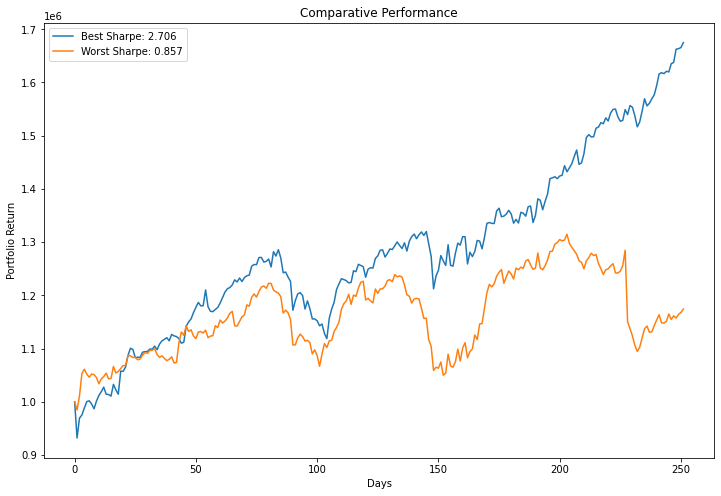

In [13]:
s_arg_max = sharpe.argmax()
s_arg_min = sharpe.argmin()

plt.figure(figsize=(12,8))
plt.plot(capital[:,s_arg_max], label='Best Sharpe: ' + str(round(sharpe.max(),3)))
plt.plot(capital[:,s_arg_min], label='Worst Sharpe: ' + str(round(sharpe.min(),3)))
plt.title('Comparative Performance')
plt.xlabel('Days')
plt.ylabel('Portfolio Return')
plt.legend()

## Conclusion